# Tutorial 1 - Partial melt aggregation of a pyMelt melting column

September 2022, Simon Matthews (simonm@hi.is)

At the time of writing the module is only compatible with importing results generated by the pyMelt mantle melting library. A previous version of the code was designed to import results from alphaMELTS, and so this functionality would be straightforward to add in the future.

First import the required libraries:

In [1]:
import DirichletMagmaMix as d
import matplotlib.pyplot as plt
import pyMelt as m
import pandas as pd
import numpy as np

## Create a pyMelt melting column
The pyMelt library can compute the melting behaviour of heterogeneous mantle including the trace element concentrations in the primary melts. The present version of pyMelt (v2.00) incorporates the INVMEL model for trace element calculations, but a future update of pyMelt will offer further options.

See the pyMelt tutorials for more information about using the library.

First we have to define the lithologies we will melt:

In [2]:
# Lherzolite (Matthews et al., 2021)
lz = m.lithologies.matthews.klb1()

# Pyroxenite (Matthews et al., 2021)
px = m.lithologies.matthews.kg1()

Next we have to combine them into a mantle object with specified mass fractions:

In [3]:
mantle = m.mantle([lz, px],
                  [0.95, 0.05], # The solid lithology proportions
                  ['lz', 'px']) # The names of the lithologies

We can then perform an adiabatic decompression melting calculation, a suitable model for mid-ocean ridges or mantle plume localities. We will use a high $T_p$ (mantle potential temperature) so that we get garnet-present melting taking place:

In [4]:
column = mantle.adiabaticMelt(1480.0)

/Users/simonmatthews/opt/anaconda3/lib/python3.7/site-packages/pyMelt/mantle_class.py:476: UserWarning: Freezing prevented.
  _warn("Freezing prevented.")


Next we need to calculate the trace element contents of the melts. There are some chemical compositions built into pyMelt which we will use here to keep things simple.

The lherzolite will have the composition of the depleted mantle from Workman & Hart (2005):

In [5]:
lz_tes = m.chemistry.workman05_dmm
lz_tes

{'Rb': 0.05,
 'Ba': 0.563,
 'Th': 0.0079,
 'U': 0.0032,
 'Nb': 0.1485,
 'Ta': 0.0096,
 'La': 0.192,
 'Ce': 0.55,
 'Pb': 0.018,
 'Pr': 0.107,
 'Nd': 0.581,
 'Sr': 7.664,
 'Zr': 5.082,
 'Hf': 0.157,
 'Sm': 0.239,
 'Eu': 0.096,
 'Ti': 716.3,
 'Gd': 0.358,
 'Tb': 0.07,
 'Dy': 0.505,
 'Ho': 0.115,
 'Y': 3.328,
 'Er': 0.348,
 'Yb': 0.365,
 'Lu': 0.058}

We used a KG1 pyroxenite above which corresponds to a mixture of 1:2 basalt:peridotite. We can do the same mixture with the trace elements, using the composition of subducted basalt estimated by Stracke et al. (2003):

In [6]:
# Mix the compositions. Use Series so that elements are mapped onto each other:
kg1_tes = (0.333 * pd.Series(m.chemistry.stracke03_bsic) +
           0.666 * pd.Series(m.chemistry.palme13_pm))

# Remove elements that only existed in one of the compositions:
kg1_tes = kg1_tes[~np.isnan(kg1_tes)]

# Convert to a dictionary to put back into pyMelt:
kg1_tes = dict(kg1_tes)

kg1_tes

{'Ba': 6.75657,
 'Ce': 3.1288014,
 'Dy': 2.1504474,
 'Er': 1.3542444,
 'Eu': 0.45720900000000003,
 'Gd': 1.7319330000000002,
 'Hf': 0.7934724000000001,
 'La': 1.0144512,
 'Lu': 0.19702278,
 'Nb': 1.04562,
 'Nd': 3.373956,
 'Pb': 0.15318,
 'Rb': 0.59274,
 'Sm': 1.1852802,
 'Sr': 41.625,
 'Ta': 0.06993,
 'Th': 0.0858474,
 'Ti': 3418.245,
 'U': 0.024242400000000004,
 'Y': 12.24108,
 'Yb': 1.3136184000000002,
 'Zr': 28.1718}

Now we can do the calculation. We will use the default options to keep things simple. This means the INVMEL model will be used, though the model is really calibrated only for lherzolite melting (so applying it to the pyroxenite isn't really correct, but it is sufficient to demonstrate the behaviour of the libraries. To make this a little better, we will increase the melt fraction prior to cpx/gt-exhaustion in the pyroxenite. See the pyMelt tutorials for ideas about how to do this better!

This step may take a little time...

In [7]:
column.calculateChemistry(elements={'lz': lz_tes,
                                    'px': kg1_tes},
                          cpxExhaustion={'lz':0.3,
                                         'px':0.5})

There is one final step- we need to apply a geological setting to the melting column. We could do this for an ocean island by specifying the lithosphere thickness:

In [8]:
oib = m.geosettings.intraPlate(column, 2.0)

We can look at the primary melt compositions:

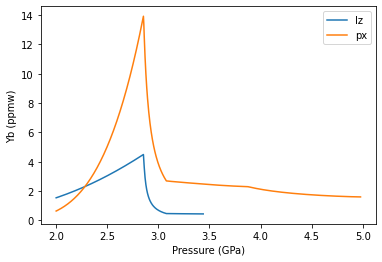

In [9]:
f, a = plt.subplots()

a.plot(oib.P, oib.lithologies['lz'].Yb, label='lz')
a.plot(oib.P, oib.lithologies['px'].Yb, label='px')

a.legend()

a.set_xlabel('Pressure (GPa)')
a.set_ylabel('Yb (ppmw)')

plt.show()

## Import the results into DirichletMagmaMix
Now we can import this geoSetting object (`oib`) directly into the DirichletMagmaMix library. While we are doing this we can add some radiogenic isotope compositions, which we will set up first. This step is optional and can be ignored.

It requires a dictionary with each lithology name as a key. The value is then a list of dictionaries for each isotope ratio:

In [10]:
isotopes={'lz': [{'ratio': 'Nd143Nd144',
                  'element': 'Nd',
                  'value': 0.51335},
                 {'ratio': 'Sr87Sr86',
                  'element': 'Sr',
                  'value': 0.702},
                 ],
          'px': [{'ratio': 'Nd143Nd144',
                  'element': 'Nd',
                  'value': 0.51290},
                  {'ratio': 'Sr87Sr86',
                  'element': 'Sr',
                  'value': 0.7035}
                ]}

The element must have been included in the chemistry calculations previously.

Now do the import:

In [28]:
unmixed = d.import_pyMelt_geoSetting(oib, isotopes=isotopes)

In the background here, DirichletMagmaMix assigned a weighting to each melt. In this case the weighting of each melt is equal (they are also weighted by their mass, which is done separately). You may not want this behaviour in some situations:
- Spreading centres should have a triangular weighting (see Rudge et al., 2013). This will be done automatically if a `spreadingCentre` geoSetting object is supplied during import.
- Active upwelling can flux more material through the base of mantle plume melting regions, and so the deeper melts should have a greater weighting. There is a facility in pyMelt to apply such a weighting, but it is not currently transmitted to DirichletMagmaMix. However, you can provide weightings as a pandas.Series during import.

## Partial melt aggregation calculations
The mixing behaviour is controlled by the mixing parameter $M$. When $M=1$ the situation corresponds to no mixing. When $M=\infty$ the melts are homogenised. Therefore $M$ can take values $>1$. You must also specify the number of samples to draw from the distribution:

In [29]:
mixed = unmixed.gen_mixed_melts(mixing_parameter=4, samples=500)

We could also calculate the completely homogenised melt composition (i.e., $M=\infty$):

In [30]:
homog = unmixed.mean_composition()

We can plot the results. During import, tracers of the lithology contributions were added with the names of the lithologies. I use the 'px' tracer to colour the points:

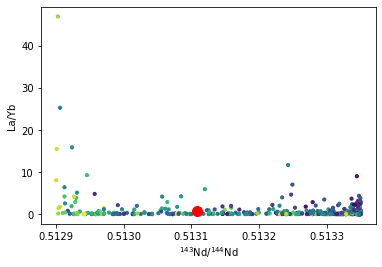

In [31]:
f, a = plt.subplots()

a.scatter(mixed.melts.Nd143Nd144, mixed.melts.La/mixed.melts.Yb, c=mixed.melts.px,
          s=10)

a.scatter(homog.Nd143Nd144, homog.La/homog.Yb, c='r', s=100)

a.set_xlabel('$^{143}$Nd/$^{144}$Nd')
a.set_ylabel('La/Yb')

plt.show()

We could try calculating a few different mixes:

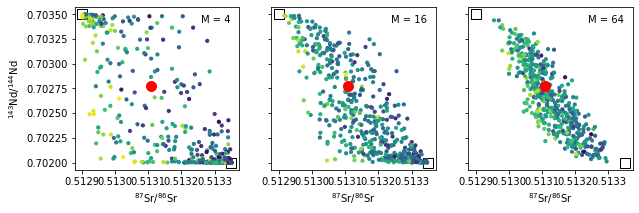

In [32]:
f, a = plt.subplots(1,3, figsize=(10,3), sharey='row')

M = [4, 16, 64]

for i in range(3):
    mixed = unmixed.gen_mixed_melts(mixing_parameter=M[i], samples=500)
    a[i].scatter(mixed.melts.Nd143Nd144, mixed.melts.Sr87Sr86, c=mixed.melts.px,
                 s=10)
    a[i].scatter(homog.Nd143Nd144, homog.Sr87Sr86, c='r', s=100)
    
    a[i].text(0.95, 0.95, 'M = ' + str(M[i]), transform=a[i].transAxes, va='top', ha='right')

    a[i].set_xlabel('$^{87}$Sr/$^{86}$Sr')
    
    a[i].scatter(isotopes['lz'][0]['value'], isotopes['lz'][1]['value'], marker='s', lw=1,
                 c='w', zorder=-10, s=100, ec='k')
    a[i].scatter(isotopes['px'][0]['value'], isotopes['px'][1]['value'], marker='s', lw=1,
                 c='w', zorder=-10, s=100, ec='k')
    
a[0].set_ylabel('$^{143}$Nd/$^{144}$Nd')
    
plt.show()

## Partial homogenisation during transport

One of the scenarios explored by Rudge et al. (2013) was the homogenisation of melts produced beneath a particular depth. DirichletMagmaMix provides a method for recreating this:

In [33]:
unmixed.homogenise(3.3) # Homogenise all melts produced beneath 3.2 GPa

Note that this permanently alters the `unmixed` object, so to increase the homogenisation threshold the pyMelt results must be re-imported. Alternatively the object could be copied using the `deepcopy` method of the `copy` library.

We can see what effect this has:

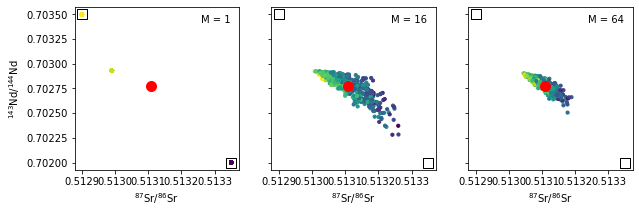

In [34]:
f, a = plt.subplots(1,3, figsize=(10,3), sharey='row')

M = [1, 16, 64]

for i in range(3):
    mixed = unmixed.gen_mixed_melts(mixing_parameter=M[i], samples=500)
    a[i].scatter(mixed.melts.Nd143Nd144, mixed.melts.Sr87Sr86, c=mixed.melts.px,
                 s=10)
    a[i].scatter(homog.Nd143Nd144, homog.Sr87Sr86, c='r', s=100)
    
    a[i].text(0.95, 0.95, 'M = ' + str(M[i]), transform=a[i].transAxes, va='top', ha='right')

    a[i].set_xlabel('$^{87}$Sr/$^{86}$Sr')
    
    a[i].scatter(isotopes['lz'][0]['value'], isotopes['lz'][1]['value'], marker='s', lw=1,
                 c='w', zorder=-10, s=100, ec='k')
    a[i].scatter(isotopes['px'][0]['value'], isotopes['px'][1]['value'], marker='s', lw=1,
                 c='w', zorder=-10, s=100, ec='k')
    
a[0].set_ylabel('$^{143}$Nd/$^{144}$Nd')
    
plt.show()

## Concurrent Mixing and Crystallisation
Finally, DirichletMagmaMixing can model concurrent mixing and crystallisation in a similar way to Rudge et al. (2013).

First, reimport the results so they are no longer partially homogenised:

In [35]:
unmixed = d.import_pyMelt_geoSetting(oib, isotopes=isotopes)

Now generate the mixture, using a set of chosen parameters. We will treat the elements as being perfectly incompatible, but partition coefficients could be specified (see the documentation).

In [37]:
mixed = unmixed.gen_cmc_melts(samples=500,
                              max_crystallisation=0.5,
                              mixing_min=2,
                              mixing_max=256,
                              partition_coefficient=None) # Could specify partition coefficients.

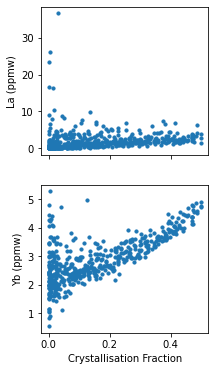

In [46]:
f, a = plt.subplots(2,1, figsize=(3,6), sharex='col')

a[0].scatter(mixed.melts.crystallisation, mixed.melts.La, s=10)
a[1].scatter(mixed.melts.crystallisation, mixed.melts.Yb, s=10)

a[1].set_xlabel('Crystallisation Fraction')
a[0].set_ylabel('La (ppmw)')
a[1].set_ylabel('Yb (ppmw)')

plt.show()
